# Возьмите MNIST, обучите на нём сеть (LeNet)

In [ ]:
!pip install torchsummary

In [ ]:
import torchvision as tv
from torchsummary import summary
from torchvision import transforms
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import time
import torch.nn.functional as F

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Загрузка и подготовка данных

In [ ]:
transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(1),
    tv.transforms.Resize((28, 28)),
    tv.transforms.ToTensor()
])

In [ ]:
train_dataset = tv.datasets.EMNIST('.', train=True, transform= transoforms, download=True, split='mnist')
test_dataset = tv.datasets.EMNIST('.', train=False, transform= transoforms, download=True, split='mnist')

In [ ]:
train_dataset[0][0].size()

torch.Size([1, 28, 28])

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size= 256)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size= 256)

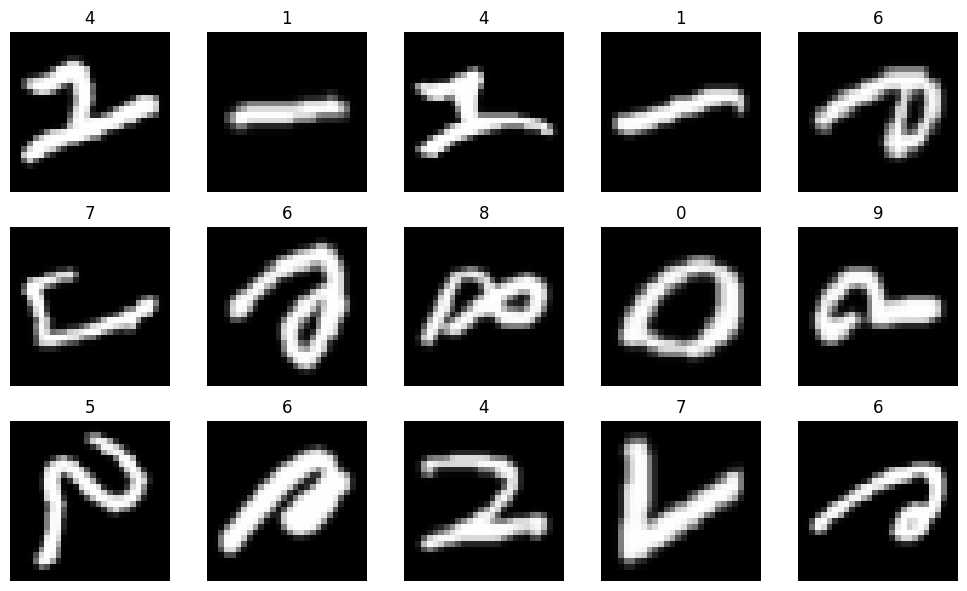

In [ ]:
rows, cols = 3, 5
num_images = rows * cols
transform_for_display = tv.transforms.Compose([tv.transforms.ToPILImage()])

# Создание новой фигуры для визуализации
fig = plt.figure(figsize=(10, 6))

for i in range(num_images):
    # Получение изображения и метки
    image, label = train_dataset[i]

    # Преобразование изображения в массив NumPy
    image = transform_for_display(image)

    # Добавление подграфа
    ax = fig.add_subplot(rows, cols, i + 1)

    # Отключение осей
    ax.axis('off')

    # Отображение изображения
    ax.imshow(image, cmap='gray')

    # Добавление подписи с классом
    ax.set_title(label)

# Вывод изображений
plt.tight_layout()
plt.show()


## Обучение модели

LeNet (LeNet-5) - это одна из первых успешных нейронных сетей, специально разработанная для распознавания рукописных цифр. Она была предложена Яном Лекуном в 1998 году и стала вехой в развитии глубокого обучения.

Основная структура сети LeNet состоит из сверточных слоёв, слоев подвыборки и полносвязанных слоев. Ниже приведено описание основных компонентов сети LeNet:

Сверточный слой (Convolutional Layer): Сверточный слой выполняет операцию свертки между входным изображением и набором фильтров (ядер), чтобы извлечь важные пространственные признаки. Также в этом слое обычно используется функция активации, например, ReLU (Rectified Linear Unit).

Слой подвыборки (Pooling Layer): Слой подвыборки уменьшает пространственные размеры предыдущего слоя, сохраняя важные признаки и улучшая робастность модели к небольшим трансляциям искажений. Обычно используется операция максимума (Max Pooling).

Полносвязанный слой (Fully Connected Layer): После нескольких сверточных слоев и слоев подвыборки следует несколько полносвязанных слоев. Эти слои представляют глубокую нейронную сеть и выполняют классификацию или регрессию на основе извлеченных признаков.

Выходной слой (Output Layer): Выходной слой определяет формат вывода модели. В случае классификации рукописных цифр, обычно используется слой Softmax, который представляет вероятности каждого класса.

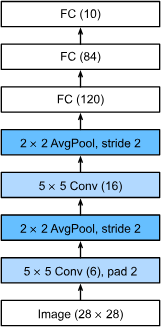

In [ ]:
class Classifier:

    def __init__(self, learning_rate=0.03, num_epochs=15, device= device, model=None):
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.device = torch.device(device)
        self.model = model.to(self.device) if model is not None else None
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.learning_rate)
        self.train_loss = []
        self.test_loss = []
        self.train_accuracy = []
        self.test_accuracy = []

    def evaluate_accuracy(self, data_loader, net):
        acc_sum, n = 0, 0
        net.eval()
        for X, y in data_loader:
            X, y = X.to(self.device), y.to(self.device)
            acc_sum += (net(X).argmax(axis=1) == y).sum().item()
            n += y.shape[0]
        return acc_sum / n

    def evaluate_loss(self, data_loader, net):
        running_loss = 0.0
        for X, y in data_loader:
            X, y = X.to(self.device), y.to(self.device)
            outputs = self.model(X)
            loss = self.criterion(outputs, y)
            running_loss += loss.item()
        return round(running_loss/len(data_loader),4)

    def fit(self, train_loader, test_loader):
        for epoch in range(self.num_epochs):
            self.model.train()
            running_loss = 0.0
            start = time.time()

            for i, data in enumerate(train_loader, 0):
                inputs, labels = data
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
                print(f"\r{(int(i/len(train_loader)*100))+1}% ", end="", flush=True)

            self.train_loss.append(round(running_loss/len(train_loader), 4))
            loss_tst = self.evaluate_loss(test_loader, self.model)
            self.test_loss.append(loss_tst)

            test_acc = self.evaluate_accuracy(test_loader, self.model)
            train_acc = self.evaluate_accuracy(train_loader, self.model)
            self.train_accuracy.append(round(train_acc,3))
            self.test_accuracy.append(round(test_acc,3))


            print(f"Epoch: [{epoch+1}/{self.num_epochs}],Time: {time.time() - start:.1f}sec.,"
            f" Train loss:{running_loss/len(train_loader):.4f},Train accuracy: {train_acc:.3f},"
            f"Test loss : {loss_tst}, Test accuracy: {test_acc:.3f}")

            torch.cuda.empty_cache()

    def predict(self, test_loader):
        self.model.eval()
        predictions = []
        with torch.no_grad():
            for data in test_loader:
                inputs, _ = data
                inputs = inputs.to(self.device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                predictions.extend(predicted.cpu().numpy())
        return predictions


In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.maxpool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.maxpool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model = LeNet()

In [ ]:
summary(model.to(device), input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
         MaxPool2d-2            [-1, 6, 12, 12]               0
            Conv2d-3             [-1, 16, 8, 8]           2,416
         MaxPool2d-4             [-1, 16, 4, 4]               0
            Linear-5                  [-1, 120]          30,840
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 44,426
Trainable params: 44,426
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.17
Estimated Total Size (MB): 0.22
----------------------------------------------------------------


In [ ]:
clf_LeNet = Classifier(model = model)

In [ ]:
clf_LeNet.fit(train_loader, test_loader)

100% Epoch: [1/15],Time: 22.8sec., Train loss:2.2981,Train accuracy: 0.191,Test loss : 2.2873, Test accuracy: 0.192
100% Epoch: [2/15],Time: 22.8sec., Train loss:1.7583,Train accuracy: 0.767,Test loss : 0.7219, Test accuracy: 0.761
100% Epoch: [3/15],Time: 21.7sec., Train loss:0.4248,Train accuracy: 0.890,Test loss : 0.3862, Test accuracy: 0.882
100% Epoch: [4/15],Time: 21.6sec., Train loss:0.2617,Train accuracy: 0.909,Test loss : 0.3128, Test accuracy: 0.902
100% Epoch: [5/15],Time: 21.9sec., Train loss:0.2016,Train accuracy: 0.927,Test loss : 0.2473, Test accuracy: 0.920
100% Epoch: [6/15],Time: 22.1sec., Train loss:0.1640,Train accuracy: 0.936,Test loss : 0.2115, Test accuracy: 0.930
100% Epoch: [7/15],Time: 22.6sec., Train loss:0.1389,Train accuracy: 0.945,Test loss : 0.1838, Test accuracy: 0.940
100% Epoch: [8/15],Time: 22.4sec., Train loss:0.1207,Train accuracy: 0.951,Test loss : 0.1599, Test accuracy: 0.947
100% Epoch: [9/15],Time: 21.4sec., Train loss:0.1073,Train accuracy: 0.9

#Возьмите какую-нибудь картинку из mnist’а

In [ ]:
image, label = train_dataset[777]

In [ ]:
image_pic = transform_for_display(image)

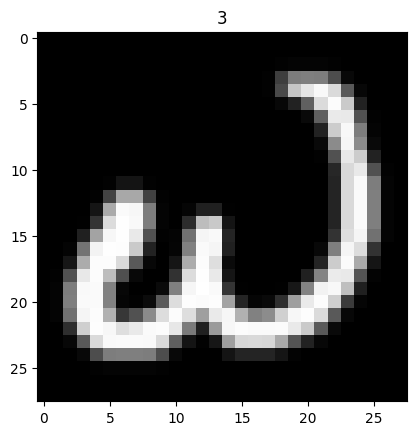

In [ ]:
plt.imshow(image_pic, cmap='gray')
plt.title(label)
plt.show()

# Обучите шум, который при добавлении к оригинальной картинке, заставит её ошибаться в пользу другого класса

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
# Функция для генерации FGSM атакующего шума
def generate_fgsm_noise(image, true_label, model, epsilon=0.1):
    image = image.unsqueeze(0)
    true_label = torch.tensor([true_label], dtype=torch.long)
    adversarial_image = image.clone().requires_grad_()

    for i in range(20):  # 10 итераций для усиления атаки
        output = model(adversarial_image)
        loss = criterion(output, true_label)
        grad = torch.autograd.grad(loss, adversarial_image)[0]
        adversarial_image = adversarial_image + epsilon * grad.sign()

    return adversarial_image

In [ ]:
# Генерация FGSM атакующего шума
eps = 0.01  # параметр для контроля силы атаки
adversarial_image = generate_fgsm_noise(image, label, model, epsilon=eps)

In [ ]:
# Предсказание для оригинального изображения
original_prediction = model(image.unsqueeze(0)).argmax().item()

In [ ]:
# Предсказание для атакованного изображения
adversarial_prediction = model(adversarial_image).argmax().item()

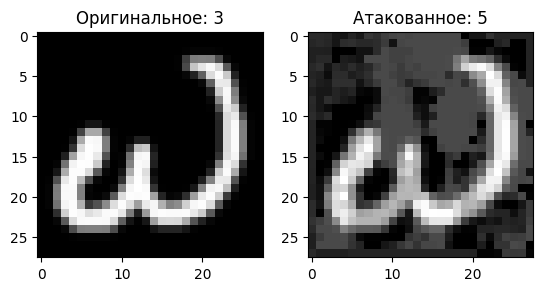

In [ ]:
# Отображение оригинального и атакованного изображений с предсказаниями
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"Оригинальное: {original_prediction}")
plt.subplot(1, 2, 2)
plt.imshow(adversarial_image.squeeze().detach(), cmap='gray')
plt.title(f"Атакованное: {adversarial_prediction}")
plt.show()